In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [3]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [4]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [5]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [6]:
corr1k = pd.read_csv("correlations1k01.csv")
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.1,0.222222,0.127049,1.022677,0.089734,0.784569,0.060216,0.971438,0.036295,0.000012,0.000096,0.000038,4.233635,995.239066,739.237105,2.817373,766.410173,528.000688,0.311041,0.152211
1,0.1,0.222222,0.105415,1.032711,0.090933,0.845908,0.068362,0.966238,0.035969,-0.000251,0.000170,0.000081,1.000755,1011.094425,755.412571,1.001292,828.288468,589.836523,0.229006,0.148617
2,0.1,0.222222,0.098759,1.078087,0.096165,0.890827,0.070022,1.006722,0.036887,0.000019,0.000215,0.000101,1.411790,1055.126074,789.554540,1.093938,871.991491,622.793887,0.217558,0.143496
3,0.1,0.222222,0.061953,0.997946,0.090424,0.873391,0.075236,0.921694,0.033880,-0.000180,0.000004,0.000097,1.454774,974.901291,734.465120,2.119852,852.587230,618.103580,0.151158,0.145072
4,0.1,0.222222,0.042830,0.944340,0.080527,0.844915,0.066799,0.940466,0.034984,-0.000155,0.000020,0.000087,1.176479,924.275103,674.475788,1.953787,823.541275,592.613491,0.124806,0.132310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.1,0.222222,0.143376,1.096443,0.096109,0.825802,0.061331,1.050753,0.039771,0.000154,0.000119,0.000038,1.125866,1077.403530,786.600822,1.949721,803.505600,562.581718,0.334733,0.150823
496,0.1,0.222222,-0.003132,0.823570,0.063127,0.831738,0.064229,0.999372,0.037648,0.000013,0.000063,0.000143,1.061691,809.364962,561.504971,4.057276,812.234099,559.610857,-0.015706,0.109339
497,0.1,0.222222,0.097533,1.085016,0.097532,0.866150,0.066600,1.005025,0.037795,0.000153,0.000167,0.000229,1.094554,1056.967853,805.163105,1.347220,853.125238,590.528061,0.259739,0.145980
498,0.1,0.222222,0.129903,1.135848,0.101566,0.870881,0.068481,1.002015,0.035056,-0.000165,0.000064,0.000051,2.391245,1108.855519,843.390021,2.472362,850.498024,602.531681,0.312418,0.157541


In [7]:
rho = 0.1
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.8181818181818181 1.0 0.22222222222222224
1.0009271523378385 0.045162390869865475 0.7716813479601854 0.03420049037930685 0.9787946188887926 0.0319192451257873 0.2970731442241376 0.07235170615160032
1.0091252946765739 0.04548001299082092 0.8302849074767453 0.03696268237114382 0.9636455585913373 0.03131806355375253 0.2153964086175293 0.06842996164189656
1.0540841440898514 0.047518799620809404 0.8739713362593898 0.038931631103022356 1.0032340316890547 0.03259234991143614 0.20608548628304796 0.06837451579368556
0.9755327620676935 0.04398316542788174 0.8553297313631533 0.03824956863588665 0.9220148998021944 0.029899567734970604 0.14053414291231361 0.06455407930707595
0.9222702493103864 0.041395819433209614 0.8281866013626497 0.03695594788521892 0.9417972976505526 0.030636626901611952 0.11360199234440282 0.06266320796836519
1.0539040115171665 0.047521255612386765 0.9096096593618878 0.04064525308137142 0.9920960158553115 0.03217885616851763 0.15863326721541698 0.06606384644200076
1.04528

0.7824167336249941 0.03468615550505637 0.9284416892782158 0.04161577434842033 0.989761425532114 0.032335815301670935 -0.15727961953835104 0.04799649242474334
0.9136193850760096 0.040923074477702916 0.9042372156067534 0.04042124521653167 0.9841828487791648 0.03201948526949318 0.010375783375561073 0.05748253873174802
0.9547396470178309 0.04289057468176418 0.7893748533824043 0.034963410681474065 0.9946305403285287 0.03247130440676929 0.20948829688056622 0.06752361500219645
1.0511123042730313 0.04747950390754536 0.7282394619389089 0.03200932474984333 1.0262679161262538 0.03359102540119698 0.4433608163370963 0.0796757286474028
0.9554019266062009 0.04291608408014537 0.7165676597570304 0.03156543923216304 1.0043551317435822 0.03292557473743732 0.33330316209100624 0.07336422454121683
0.9526157605129358 0.042731623656885924 0.8871693738322937 0.03964056562033701 0.9923575527975503 0.03228340727075431 0.07376988950591734 0.06098607050873982
0.93760694519605 0.041945692492878044 0.704811777338544

1.0422538206493133 0.04695637003506111 0.9053421058454131 0.0403583361331449 1.0152037566876033 0.03297555445296695 0.15122649650327633 0.06554547004132184
0.95439653912101 0.04279564703099901 0.8371217148548579 0.03728036382782481 0.9881777649050967 0.03219019337444757 0.14009291861039047 0.06419158282054924
0.9998382256725648 0.04507790672688112 0.8734718451148021 0.039082118389341725 0.9319062317292494 0.030203089094562093 0.14467138381678923 0.0649500220438516
0.93028441104682 0.04148917100443169 0.8731885522888136 0.0388212193697205 1.0788180721280958 0.03530090421140108 0.06538777748327775 0.060234788601679655
1.1144633643070565 0.05041317901338575 0.7902752987831562 0.0349337650198567 1.0425843187989365 0.034014047063468215 0.41022168606696435 0.07893767852043493
0.9947192496678168 0.044767893510551396 0.8327938293264552 0.037023226709305294 0.9893664189849256 0.03220494377231769 0.19443638345918487 0.06724757253006382
1.023349415505924 0.04613558611114151 0.7356185857492628 0.0

0.9470778866244514 0.042484403420176876 0.8652634549802652 0.03848803737053668 1.0122724750041034 0.03299204789533133 0.09455435933793381 0.06188424722568513
0.9417031404932024 0.04211377751870423 0.8334828130341296 0.0368824588999105 1.0711660865557304 0.035074388688372427 0.12984110261988246 0.06345907207717054
1.081883174351196 0.04871724320693293 0.8352212178903529 0.0369980885714905 1.063133390959075 0.03467368045655884 0.295325299665968 0.07291626358176283
1.0881968927019907 0.04914495480205126 0.7094041603688954 0.03117198252608166 1.04167508796379 0.034144096027873466 0.5339589947373867 0.08439547136155921
1.0631804066120916 0.04796698391645759 0.8520494490743556 0.03786716410495546 1.010418915845313 0.03285579005961985 0.24779190664004666 0.07049280491316298
1.0734049415130973 0.048485766157121614 0.9575755171712873 0.04298939959382567 0.9894216649418726 0.03203982658322211 0.12096113806666058 0.06448365503813681
1.006953530508742 0.04519047860812657 0.8878568120296043 0.03955

0.9983871698585384 0.04484671898736329 0.7668425102347488 0.033800620812948254 1.0641072423914393 0.03488408132687295 0.3019455188431171 0.07239215674488061
0.8948903197190599 0.03972225966162562 0.9400389331996445 0.04189535597607687 1.1133221192406715 0.03645861047346494 -0.04802845061630657 0.05422848006894642
1.0009123772431994 0.045024382986582075 0.7545903925135421 0.03335035796269134 1.036567333643827 0.03395019558938461 0.32643138207625233 0.07373653854994743
0.9256068870652758 0.041491605182667035 0.8396967868788495 0.03731264856262081 1.0190832224954889 0.033280393511243976 0.10231085973992338 0.06211690510431448
0.9911297333490684 0.044821368552752795 0.7022437702958384 0.031044142333007032 0.9135360985898734 0.029777183711117476 0.4113756152390349 0.07753232241952487
0.936321824916 0.04203712863378367 0.8640697196843065 0.03848232019545101 1.0039941857571837 0.03272212093035741 0.08361837428823607 0.0613415961114136
1.0479005747909822 0.04743947135471384 0.8682500820760981 

1.070851358088655 0.0484354428570315 0.7769771241351398 0.034364944979765936 0.9920855272129719 0.03231922109766198 0.3782276528162 0.07688827261864105
1.0536297886249395 0.04772042782612859 0.7853842200410364 0.03487211085006725 0.938154330651825 0.030473798817303794 0.34154692918312934 0.0750232640680756
1.0422072242950446 0.04710234891645773 0.7943924008630981 0.03528093832332894 0.9581853338169717 0.03115345976841269 0.3119551787790248 0.07346136897142355
0.9499046468224771 0.04255254962605982 0.8226401510907917 0.036464297560833296 1.0327539366830958 0.03374818926582562 0.15470250943007974 0.06478820565952849
0.8279965719012946 0.03684782524076831 0.9121515034416284 0.04087445898250704 0.9858870762453139 0.032160339622620326 -0.09225981782939546 0.051663060320633676
1.0828894705767234 0.04903344382142368 0.8672113172977576 0.038712308193860165 0.9468277596008918 0.03066766549090065 0.24870311189090782 0.07083449192876834
0.9747008324003653 0.04372924774366087 0.7837466992247197 0.

0.8152803466311809 0.0363611833100223 0.7776323937016155 0.034435876830188415 0.9803770303003624 0.03213345310668483 0.04841356048756787 0.05831565072045534
0.9497913599121782 0.042517793452832735 0.7868633807499791 0.03472123641009848 1.0749002045662568 0.03527291074763743 0.2070600604223168 0.06731125704973172
1.033182159543558 0.04645455647004135 0.8382802676506028 0.037222260332277164 1.0343111389238706 0.033713553560307474 0.2325020633483296 0.06942558544437576
1.0134045366873705 0.04566102302352632 0.7637956930410642 0.03375917789724787 0.999231131270495 0.03262234416940585 0.3268005383121302 0.07375956571903068
0.9576771088023748 0.04279163815247595 0.7735263103612108 0.03409008790815029 1.1113810537508177 0.03657429234007028 0.23806662549742072 0.06888388044238691
1.1073065449105364 0.050092928373500975 0.7967357520597357 0.035221849164141096 1.0229547419880405 0.033328857040035346 0.389804012243592 0.0777986190984727
0.9059916976310463 0.040586861792871465 0.8312579915656572 0

1.0590294767711348 0.047744285736730056 0.7693156728726244 0.033918593361911026 1.0510196110838514 0.0343740779501552 0.37658637944644907 0.07661958848551888
1.0042326769239245 0.04529850313594127 0.7597532610497728 0.0336241239017482 0.9691076005462813 0.03159628279800031 0.32178791248141203 0.07345666742392043
0.9611942275033665 0.043266201920350425 0.7959951037851172 0.03539023509045849 0.9464537935089431 0.030801806648050205 0.20753786415606598 0.06756857251373793
1.0699356086826013 0.04817177260716875 0.9606416019380165 0.042833007827359125 1.062122915612297 0.03450022148509901 0.1137718859188411 0.0638327009825158
1.08824386337814 0.04918975361136239 0.8437109972042807 0.037491116517116486 1.0103583374324243 0.03284995567857336 0.28983012783304113 0.07284882723131002
0.9556324202449686 0.04298569376081567 0.8365164803339857 0.03725448864173085 0.959324377456472 0.031201006109483693 0.14239521003032113 0.06436489677578597
0.8467691378644939 0.03776210489399527 0.824955282996013 0.

In [8]:
corr1k['A1'] = A1_list
corr1k['A2'] = A2_list
corr1k['dA1'] = dA1_list
corr1k['dA2'] = dA2_list
corr1k['D'] = D_list
corr1k['dD'] = dD_list
corr1k['dA1dA2'] = dA1dA2_list
corr1k['dA1dD'] = dA1dD_list
corr1k['dA2dD'] = dA2dD_list
corr1k['C'] = C_list
corr1k['dC'] = dC_list
corr1k['tau1'] = tau1_list
corr1k['tau2'] = tau2_list
corr1k['dtau1'] = dtau1_list
corr1k['dtau2'] = dtau2_list

In [9]:
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.1,0.222222,0.127049,1.022677,0.089734,0.784569,0.060216,0.971438,0.036295,0.000012,...,0.031919,0.000530,0.000861,0.000627,0.297073,0.072352,1.022612,0.788400,0.284715,0.285153
1,0.1,0.222222,0.105415,1.032711,0.090933,0.845908,0.068362,0.966238,0.035969,-0.000251,...,0.031318,0.000586,0.000853,0.000674,0.215396,0.068430,1.047196,0.861608,0.291545,0.291891
2,0.1,0.222222,0.098759,1.078087,0.096165,0.890827,0.070022,1.006722,0.036887,0.000019,...,0.032592,0.000646,0.000928,0.000740,0.206085,0.068375,1.050686,0.871154,0.286344,0.286686
3,0.1,0.222222,0.061953,0.997946,0.090424,0.873391,0.075236,0.921694,0.033880,-0.000180,...,0.029900,0.000592,0.000787,0.000672,0.140534,0.064554,1.058044,0.927675,0.300219,0.300457
4,0.1,0.222222,0.042830,0.944340,0.080527,0.844915,0.066799,0.940466,0.034984,-0.000155,...,0.030637,0.000531,0.000754,0.000661,0.113602,0.062663,0.979266,0.879368,0.281000,0.281182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.1,0.222222,0.143376,1.096443,0.096109,0.825802,0.061331,1.050753,0.039771,0.000154,...,0.034245,0.000595,0.000990,0.000704,0.319118,0.074001,1.020566,0.773673,0.274322,0.274804
496,0.1,0.222222,-0.003132,0.823570,0.063127,0.831738,0.064229,0.999372,0.037648,0.000013,...,0.032929,0.000441,0.000688,0.000694,-0.008016,0.055601,0.807356,0.813880,0.237574,0.237564
497,0.1,0.222222,0.097533,1.085016,0.097532,0.866150,0.066600,1.005025,0.037795,0.000153,...,0.032654,0.000630,0.000935,0.000719,0.245672,0.070356,1.055280,0.847157,0.287212,0.287606
498,0.1,0.222222,0.129903,1.135848,0.101566,0.870881,0.068481,1.002015,0.035056,-0.000165,...,0.032514,0.000668,0.000983,0.000718,0.298580,0.073508,1.108838,0.853886,0.298156,0.298647


In [10]:
# display statistics
print(corr1k['A1'].mean(),corr1k['A1'].std(),corr1k['dA1'].mean(),corr1k['dA1'].std())
print(corr1k['a1'].mean(),corr1k['a1'].std(),corr1k['da1'].mean(),corr1k['da1'].std())
print(corr1k['A2'].mean(),corr1k['A2'].std(),corr1k['dA2'].mean(),corr1k['dA2'].std())
print(corr1k['a2'].mean(),corr1k['a2'].std(),corr1k['da2'].mean(),corr1k['da2'].std())
print(corr1k['C'].mean(),corr1k['C'].std(),corr1k['dC'].mean(),corr1k['dC'].std())
print(corr1k['c'].mean(),corr1k['c'].std(),corr1k['dc'].mean(),corr1k['dc'].std())

1.0009097602126584 0.08250452574969963 0.045054797685173315 0.003923243185644934
1.0224488390530926 0.0860058998278933 0.08857791415998623 0.011397958681701468
0.8215342733699315 0.06406448537258858 0.036480231033419866 0.0030212485154100326
0.8360059161716141 0.06634152577458714 0.06537333721902135 0.00787313360572631
0.22622089022089492 0.14380794002924963 0.06880487975932126 0.007596019372638402
0.23754145265237833 0.1498228569754731 0.14393835492147275 0.018024528392443315


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


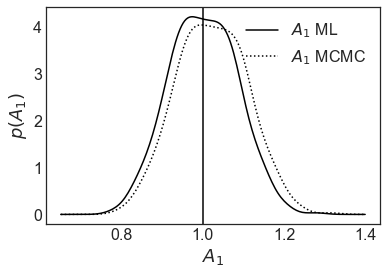

In [11]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k['A1'])
densitya1 = gaussian_kde(corr1k['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde01.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


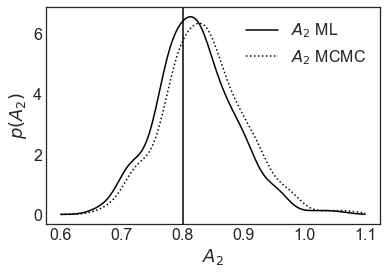

In [12]:
plt.figure(facecolor="white")
xs = np.linspace(0.6,1.1,200)
densityA2 = gaussian_kde(corr1k['A2'])
densitya2 = gaussian_kde(corr1k['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=0.8,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde01.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
# display statistics
print(corr1k['dA1dA2'].mean(),corr1k['dA1dA2'].std(),corr1k['dA1dD'].mean(),corr1k['dA2dD'].mean())
print(corr1k['da1da2'].mean(),corr1k['dA1dA2'].std(),corr1k['da1dd'].mean(),corr1k['dasdd'].mean())

0.0005661625025739938 7.222955789703958e-05 0.0008782536074538177 0.0006906766272349207
9.137407823433573e-06 7.222955789703958e-05 7.725191777482991e-05 8.012475147711543e-05


(array([ 3.,  5., 10., 15., 17., 14., 35., 27., 37., 38., 34., 38., 32.,
        34., 41., 31., 26., 19., 12.,  9., 10.,  4.,  5.,  1.,  0.,  1.,
         1.,  0.,  0.,  1.]),
 array([0.06194703, 0.06426412, 0.06658121, 0.06889831, 0.0712154 ,
        0.0735325 , 0.07584959, 0.07816668, 0.08048378, 0.08280087,
        0.08511796, 0.08743506, 0.08975215, 0.09206924, 0.09438634,
        0.09670343, 0.09902053, 0.10133762, 0.10365471, 0.10597181,
        0.1082889 , 0.11060599, 0.11292309, 0.11524018, 0.11755727,
        0.11987437, 0.12219146, 0.12450856, 0.12682565, 0.12914274,
        0.13145984]),
 <BarContainer object of 30 artists>)

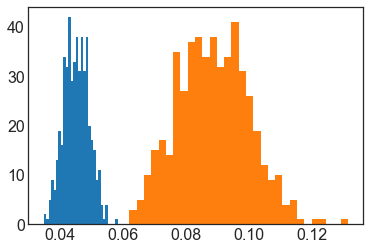

In [14]:
plt.hist(corr1k['dA1'],bins=30)
plt.hist(corr1k['da1'],bins=30)

(array([ 3.,  2.,  4.,  9., 16., 14., 17., 25., 41., 34., 53., 50., 41.,
        33., 32., 24., 22., 15., 23., 11., 12.,  6.,  1.,  5.,  0.,  0.,
         2.,  1.,  1.,  3.]),
 array([0.04590219, 0.04750443, 0.04910666, 0.05070889, 0.05231112,
        0.05391335, 0.05551558, 0.05711781, 0.05872004, 0.06032227,
        0.0619245 , 0.06352673, 0.06512896, 0.0667312 , 0.06833343,
        0.06993566, 0.07153789, 0.07314012, 0.07474235, 0.07634458,
        0.07794681, 0.07954904, 0.08115127, 0.0827535 , 0.08435573,
        0.08595797, 0.0875602 , 0.08916243, 0.09076466, 0.09236689,
        0.09396912]),
 <BarContainer object of 30 artists>)

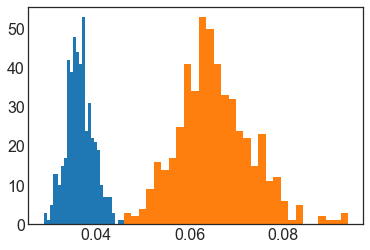

In [15]:
plt.hist(corr1k['dA2'],bins=30)
plt.hist(corr1k['da2'],bins=30)

In [16]:
print(corr1k['A1'].std()/corr1k['dA1'].mean())
print(corr1k['A2'].std()/corr1k['dA2'].mean())
print(corr1k['D'].std()/corr1k['dD'].mean())
print(corr1k['dA1dA2'].mean()/corr1k['da1da2'].mean())
print(corr1k['dA1dD'].mean()/corr1k['da1dd'].mean())
print(corr1k['dA2dD'].mean()/corr1k['dasdd'].mean())

1.831204000209068
1.7561425341275534
1.1900687739038676
61.960953643989406
11.368696502962012
8.620015844070181


(array([ 3.,  1.,  1.,  2.,  7.,  8., 17., 15., 36., 50., 50., 47., 64.,
        54., 48., 26., 27., 18.,  3., 11.,  1.,  5.,  2.,  1.,  0.,  1.,
         1.,  0.,  0.,  1.]),
 array([-3.91513439e-04, -3.58589193e-04, -3.25664947e-04, -2.92740701e-04,
        -2.59816455e-04, -2.26892209e-04, -1.93967962e-04, -1.61043716e-04,
        -1.28119470e-04, -9.51952238e-05, -6.22709777e-05, -2.93467315e-05,
         3.57751471e-06,  3.65017609e-05,  6.94260071e-05,  1.02350253e-04,
         1.35274499e-04,  1.68198746e-04,  2.01122992e-04,  2.34047238e-04,
         2.66971484e-04,  2.99895730e-04,  3.32819976e-04,  3.65744223e-04,
         3.98668469e-04,  4.31592715e-04,  4.64516961e-04,  4.97441207e-04,
         5.30365454e-04,  5.63289700e-04,  5.96213946e-04]),
 <BarContainer object of 30 artists>)

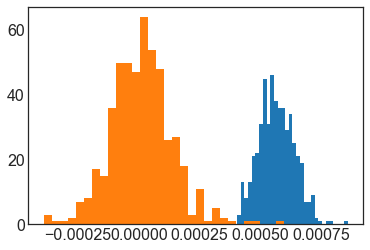

In [17]:
plt.hist(corr1k['dA1dA2'],bins=30)
plt.hist(corr1k['da1da2'],bins=30)

(array([ 1.,  0.,  0.,  1.,  4.,  5.,  2.,  4.,  7., 12., 16., 22., 21.,
        31., 43., 36., 55., 34., 35., 29., 32., 29., 28., 20.,  8.,  9.,
         6.,  3.,  6.,  1.]),
 array([-1.78258118e-04, -1.63231597e-04, -1.48205077e-04, -1.33178556e-04,
        -1.18152035e-04, -1.03125514e-04, -8.80989934e-05, -7.30724726e-05,
        -5.80459518e-05, -4.30194309e-05, -2.79929101e-05, -1.29663893e-05,
         2.06013151e-06,  1.70866523e-05,  3.21131731e-05,  4.71396940e-05,
         6.21662148e-05,  7.71927356e-05,  9.22192564e-05,  1.07245777e-04,
         1.22272298e-04,  1.37298819e-04,  1.52325340e-04,  1.67351860e-04,
         1.82378381e-04,  1.97404902e-04,  2.12431423e-04,  2.27457944e-04,
         2.42484465e-04,  2.57510985e-04,  2.72537506e-04]),
 <BarContainer object of 30 artists>)

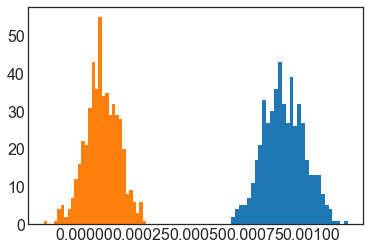

In [18]:
plt.hist(corr1k['dA1dD'],bins=30)
plt.hist(corr1k['da1dd'],bins=30)

(array([ 1.,  3.,  3.,  6.,  6., 14., 13., 19., 26., 28., 31., 29., 41.,
        46., 45., 30., 35., 24., 30., 25., 18.,  7.,  6.,  5.,  3.,  1.,
         2.,  2.,  0.,  1.]),
 array([-7.04284624e-05, -5.93843411e-05, -4.83402198e-05, -3.72960985e-05,
        -2.62519772e-05, -1.52078560e-05, -4.16373467e-06,  6.88038661e-06,
         1.79245079e-05,  2.89686292e-05,  4.00127505e-05,  5.10568717e-05,
         6.21009930e-05,  7.31451143e-05,  8.41892356e-05,  9.52333569e-05,
         1.06277478e-04,  1.17321599e-04,  1.28365721e-04,  1.39409842e-04,
         1.50453963e-04,  1.61498085e-04,  1.72542206e-04,  1.83586327e-04,
         1.94630448e-04,  2.05674570e-04,  2.16718691e-04,  2.27762812e-04,
         2.38806934e-04,  2.49851055e-04,  2.60895176e-04]),
 <BarContainer object of 30 artists>)

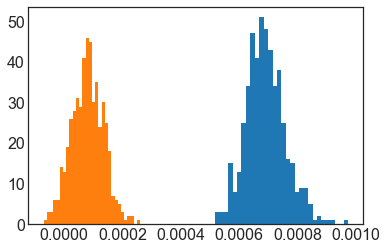

In [19]:
plt.hist(corr1k['dA2dD'],bins=30)
plt.hist(corr1k['dasdd'],bins=30)

[0.33747255 0.01516218]
factor of underestimation:  2.963203983121872


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


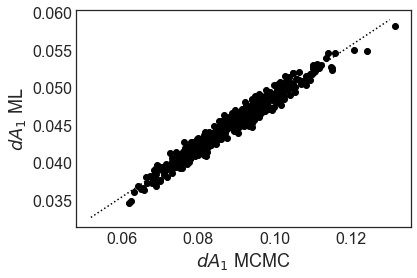

In [20]:
p1 = np.polyfit(corr1k['da1'],corr1k['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da1'],corr1k['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde01.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.37565133 0.01192265]
factor of underestimation:  2.6620429865228457


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


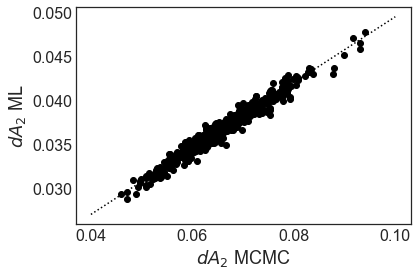

In [21]:
p1 = np.polyfit(corr1k['da2'],corr1k['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.04,0.1,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da2'],corr1k['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
#plt.xlim((0.005,0.008))
#plt.ylim((0.004,0.008))
plt.savefig("dA2corrkde01.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
corr1k['dA2'].min()

0.028691916255270355